## Set up

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
from pathlib import Path
from typing import Iterable
from concurrent.futures import ProcessPoolExecutor

import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import scipy.sparse as sps
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm, trange

from Data_manager.competition import load, load_raw, split_urm
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.BaseRecommender import BaseRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommenderICM import RP3betaRecommenderICM
from Recommenders.Hybrid import ScoresHybridRecommender, UserWideHybridRecommender, ScoresMultipleHybridRecommender
from Recommenders.KNN.ItemKNN_CFCBF_Hybrid_Recommender import (
    ItemKNN_CFCBF_Hybrid_Recommender,
)
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender, SLIMElasticNetICMRecommender

In [3]:
sns.set_theme()

In [4]:
TEST_ID_PATH = Path() / "Data_manager_split_datasets" / "competition" / "data_target_users_test.csv"
TEST_ID_PATH.exists()

True

In [5]:
TRAINING_SET = "all"
METRIC = "recall"

In [22]:
BASE_MODELS_DIR = Path() / "models"
MODELS_DIR = BASE_MODELS_DIR / TRAINING_SET / METRIC
MODELS_DIR.exists()

True

In [7]:
SUBMISSION_PATH = Path("submission.csv")

In [8]:
test_df = pd.read_csv(TEST_ID_PATH)
print(test_df.info())
test_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34231 entries, 0 to 34230
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  34231 non-null  int64
dtypes: int64(1)
memory usage: 267.6 KB
None


,user_id
0,0
1,1
2,2
3,3
4,4
...,...
34226,35729
34227,35730
34228,35731
34229,35734


In [9]:
ICM_all, URM_all, URM_train, URM_validation, URM_test = load()
if TRAINING_SET == "all":
    URM_train = URM_all

In [10]:
cutoff_list = [5, 10, 15]

evaluator_train = EvaluatorHoldout(URM_train, cutoff_list=cutoff_list, exclude_seen=False)
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=cutoff_list)
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=cutoff_list)

EvaluatorHoldout: Ignoring 1909 ( 5.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 175 ( 0.5%) Users that have less than 1 test interactions


In [11]:
recommender_object = None

In [12]:
_, urm_df = load_raw()

_, urm_val_df, urm_test_df = split_urm(urm_df)
urm_valtest_df = pd.concat([urm_val_df, urm_test_df])

n_users = urm_df.user_id.nunique()
n_items = urm_df.item_id.nunique()

def urm_df_to_csr(df: pd.DataFrame) -> sps.csr_matrix:
    return sps.csr_matrix(
        (df.data, (df.user_id, df.item_id)),
        shape=(n_users, n_items),
    )

### Helper functions

In [13]:
def recommend(
    recommender: BaseRecommender,
    user_ids: Iterable[int],
    chunk_size: int = 1000,
    cutoff: int = 10,
    **recommender_kwargs,
) -> list[list[str]]:
    recommendation_chunks: list[list[list]] = [
        recommender.recommend(
            user_ids[i : i + chunk_size],
            cutoff=cutoff,
            **recommender_kwargs,
        )
        for i in trange(0, len(user_ids), chunk_size, desc="Chunk")
    ]
    recommendation_ids = [
        recommendation for chunk in recommendation_chunks for recommendation in chunk
    ]
    return recommendation_ids

In [14]:
def encode_recommendation(recommendation: list[str]) -> str:
    return " ".join([str(item) for item in recommendation])

In [15]:
def evaluate_recommender(recommender: BaseRecommender, fit_params: dict, save: bool = False, name: str | None = None):
    recommender.fit(**fit_params)
    train_result_df, _ = evaluator_train.evaluateRecommender(recommender)
    validation_result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    display(train_result_df)
    display(validation_result_df)
    if save and name is not None:
        with (MODELS_DIR / f"{name}.pkl").open("wb") as f:
            pickle.dump(recommender, f)

## Develop model

### Hybridisation advice

You can build a hybrid with any number of techniques and models, be advised however that optimizing them is difficult.
* If you use already trained and optimized models and try to combine them you have a weight per each model and possibly a normalization. If you put together 10 models it will be difficult for the optimizer to find good hyperparameters due to a number of problems, for example the noise introduced by the lower performing algorithms;
* If you decide to try to optimize both the hybrid hyperparameters and each single model hyperparameters all at once, you end up with hundreds of hyperparameters to optimize. In theory you could be able to find a better result, in practice you will likely not.
* Some strategies can be used to minimize this, for example some smart initial points you provide to the optimizer... Maybe you start from all the hyperparameter configurations of the single models taken independently that you have already optimized, you use them as initialization points for the optimizer and then you try to *further* optimize them as part of the hybrid. (may be complicated, result is not guaranteed) 

A good solution is to proceed incrementally. For example:
* Start with the best model and set a weight and normalization, let's say 1.0 and l1;
* Add the second-best model and try to create a hybrid of the two optimizing only weight and normalization of the model you are trying to add;
* Once the optimization concludes, check if the hybrid is better than before or not. If it is better keep the new hybrid, if not remove the second-best model.
* Continue trying to add the third-best, fourth-best and so on...
* If you are lucky every now and then a new model can be added and the quality improves. (again, result not guaranteed)


Alternatively you can combine the model predictions with more complex strategies, for example with XGBoost. This is usually the go-to approach for hybrids that we use in the international challenges but goes beyond the scope of this course.

### Single models

#### KNN

In [15]:
BESMT_ITEM_KNN_CF = {
    "topK": 5,
    "shrink": 224,
    "similarity": "asymmetric",
    "normalize": True,
    "asymmetric_alpha": 0.0,
    "feature_weighting": "TF-IDF",
}

itemknn_cf_recommender = ItemKNNCFRecommender(URM_train)
evaluate_recommender(
    itemknn_cf_recommender, BESMT_ITEM_KNN_CF, save=True, name="itemknn_cf"
)

Similarity column 38121 (100.0%), 4949.36 column/sec. Elapsed time 7.70 sec
EvaluatorHoldout: Processed 35736 (100.0%) in 20.29 sec. Users per second: 1761
EvaluatorHoldout: Processed 33827 (100.0%) in 17.55 sec. Users per second: 1928


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.489551,0.489551,0.07018,0.393766,0.393766,0.637563,0.493119,0.122762,0.853705,1.131101,...,1.0,0.853705,1.0,0.184134,13.068823,0.99981,0.301178,0.885078,1.256341,0.098191
10,0.444938,0.444938,0.12468,0.32852,0.32852,0.647485,0.461225,0.194779,0.925509,1.392648,...,1.0,0.925509,1.0,0.241917,13.48579,0.999883,0.395691,0.913317,1.158557,0.197906
15,0.406201,0.406212,0.167122,0.285327,0.285332,0.64957,0.4316,0.236813,0.951589,1.521378,...,1.0,0.951589,1.0,0.285641,13.737741,0.999916,0.467208,0.93038,1.10231,0.29828


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.94658,0.0,0.94658,0.218369,13.338937,0.999873,0.357175,0.903371,1.167886,0.098865
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.94658,0.0,0.94658,0.274905,13.689384,0.999919,0.449647,0.927105,1.089085,0.198946
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.94658,0.0,0.94658,0.322791,13.92945,0.999944,0.527973,0.943364,1.027371,0.300003


In [ ]:
BEST_ITEM_KNN_CF_CBF = {
    "topK": 96,
    "shrink": 966,
    "similarity": "cosine",
    "normalize": True,
    "feature_weighting": "BM25",
    "ICM_weight": 0.015154282137075726,
}

itemknn_cfcbf_recommender = ItemKNN_CFCBF_Hybrid_Recommender(URM_train, ICM_all)
evaluate_recommender(itemknn_cfcbf_recommender, BEST_ITEM_KNN_CF_CBF, save=True, name="itemknn_cfcbf")

Similarity column 38121 (100.0%), 906.98 column/sec. Elapsed time 42.03 sec
EvaluatorHoldout: Processed 35736 (100.0%) in 24.14 sec. Users per second: 1480
EvaluatorHoldout: Processed 33827 (100.0%) in 21.92 sec. Users per second: 1543


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.71637,0.71637,0.154724,0.655816,0.655816,0.826783,0.72575,0.254484,0.942383,1.67132,...,1.0,0.942383,1.0,0.434472,14.259048,0.999955,0.716159,0.966071,0.7207,0.148373
10,0.648735,0.649344,0.272397,0.566722,0.56716,0.831467,0.676481,0.383688,0.976158,2.051473,...,1.0,0.976158,1.0,0.489582,14.42759,0.999967,0.806999,0.97749,0.774712,0.294531
15,0.581365,0.596242,0.354176,0.491005,0.501795,0.832263,0.635114,0.440185,0.986232,2.226782,...,1.0,0.986232,1.0,0.498088,14.461546,0.999971,0.82102,0.97979,0.808842,0.439832


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.052715,0.077676,0.066051,0.029976,0.044062,0.123436,0.071605,0.058635,0.222042,0.136012,...,0.94658,0.21018,0.94658,0.23935,13.491391,0.999904,0.39453,0.914061,0.906065,0.144361
10,0.041875,0.105138,0.101473,0.018124,0.045359,0.135821,0.082808,0.059285,0.315517,0.156337,...,0.94658,0.298662,0.94658,0.285614,13.756012,0.999929,0.470789,0.93199,0.910925,0.289016
15,0.035737,0.128873,0.127211,0.013188,0.04741,0.140396,0.091718,0.055798,0.373666,0.165519,...,0.94658,0.353705,0.94658,0.316501,13.907368,0.999942,0.521702,0.942244,0.90951,0.433972


#### SLIM

In [ ]:
BEST_SLIM_ELASTICNET = {
    "l1_ratio": 0.4408355927953408,
    "alpha": 0.00013519978876092592,
    "positive_only": False,
    "topK": 59,
    "do_feature_selection": True,
}

# BEST_SLIM_ELASTICNET = {
#     "topK": 1000,
#     "l1_ratio": 0.003266986021483405,
#     "alpha": 0.001,
#     "positive_only": True,
#     "do_feature_selection": True,
# }

slim_elasticnet_recommender = SLIMElasticNetRecommender(URM_train)
evaluate_recommender(slim_elasticnet_recommender, BEST_SLIM_ELASTICNET, save=True, name="slim_elasticnet")

Similarity column 38121 (100.0%), 5756.53 column/sec. Elapsed time 6.62 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.20 min. Items per second: 530.79
EvaluatorHoldout: Processed 35736 (100.0%) in 23.12 sec. Users per second: 1545
EvaluatorHoldout: Processed 33827 (100.0%) in 20.79 sec. Users per second: 1627


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.414641,0.414641,0.078903,0.324902,0.324902,0.577449,0.422603,0.132578,0.788672,0.976977,...,1.0,0.788672,1.0,0.168406,12.939814,0.999787,0.277591,0.876691,1.472235,0.138095
10,0.369406,0.369599,0.136777,0.260756,0.260851,0.588559,0.388683,0.199636,0.870691,1.188584,...,1.0,0.870691,1.0,0.214449,13.293674,0.999851,0.353486,0.900665,1.410097,0.277368
15,0.335686,0.342069,0.181921,0.22314,0.226324,0.591546,0.365935,0.235964,0.908188,1.29361,...,1.0,0.908188,1.0,0.243923,13.478599,0.999877,0.402069,0.913194,1.380128,0.417005


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.063908,0.093876,0.079586,0.037049,0.054087,0.149905,0.087131,0.07089,0.263369,0.166707,...,0.94658,0.2493,0.94658,0.178402,13.019912,0.999807,0.294068,0.882118,1.463491,0.138209
10,0.050474,0.125491,0.120946,0.022556,0.055577,0.163138,0.099938,0.071225,0.362314,0.191131,...,0.94658,0.342959,0.94658,0.221888,13.338467,0.999859,0.365747,0.9037,1.410222,0.277402
15,0.042763,0.151413,0.14931,0.01648,0.057911,0.16776,0.109733,0.066484,0.420759,0.201864,...,0.94658,0.398282,0.94658,0.248531,13.499859,0.99988,0.409665,0.914635,1.386794,0.416813


In [ ]:
BEST_SLIM_ELASTICNET_ICM = {
    "topK": 1000,
    "l1_ratio": 2.9986827630822705e-05,
    "alpha": 0.001,
    "positive_only": False,
    "do_feature_selection": True,
}

slim_elasticnet_icm_recommender = SLIMElasticNetICMRecommender(URM_train, ICM_all)
evaluate_recommender(slim_elasticnet_icm_recommender, BEST_SLIM_ELASTICNET_ICM)

Similarity column 38121 (100.0%), 925.57 column/sec. Elapsed time 41.19 sec
SLIMElasticNetICMRecommender: Processed 38121 (100.0%) in 2.96 min. Items per second: 214.65
EvaluatorHoldout: Processed 35736 (100.0%) in 23.52 sec. Users per second: 1520
EvaluatorHoldout: Processed 33827 (100.0%) in 22.19 sec. Users per second: 1524


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.265223,0.265223,0.050097,0.178294,0.178294,0.350392,0.255445,0.084275,0.598136,0.567401,...,1.0,0.598136,1.0,0.140155,12.626959,0.999659,0.224158,0.849029,1.132563,0.153066
10,0.25455,0.254681,0.094572,0.147938,0.147993,0.370823,0.251833,0.137908,0.747705,0.726537,...,1.0,0.747705,1.0,0.190157,13.081676,0.999773,0.304128,0.879604,1.082281,0.307532
15,0.23812,0.242686,0.129652,0.128753,0.13066,0.375743,0.244219,0.167891,0.809632,0.806832,...,1.0,0.809632,1.0,0.224921,13.330846,0.99982,0.359728,0.896358,1.055673,0.462457


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.05129,0.076129,0.064904,0.028094,0.041489,0.117032,0.068515,0.0573,0.217696,0.128249,...,0.94658,0.206067,0.94658,0.14548,12.700767,0.9997,0.232674,0.853992,1.117268,0.153199
10,0.042463,0.10744,0.103628,0.017458,0.043812,0.13028,0.081671,0.060241,0.317202,0.150297,...,0.94658,0.300257,0.94658,0.195118,13.134701,0.999795,0.312062,0.88317,1.077151,0.307512
15,0.036549,0.131714,0.129949,0.012839,0.046055,0.134967,0.090964,0.057051,0.376563,0.159998,...,0.94658,0.356447,0.94658,0.228812,13.367209,0.999833,0.365952,0.898803,1.055811,0.462192


#### $RP_\beta^3$

In [ ]:
BEST_RP3_ICM = {
    "topK": 11,
    "alpha": 1.9811525250064195,
    "beta": 0.6832513917848906,
    "delta": 0.0037274512973076712,
    "normalize_similarity": True,
    "implicit": True,
    "min_rating": 1.0,
}

rp3_icm = RP3betaRecommenderICM(URM_train, ICM_all)
evaluate_recommender(rp3_icm, BEST_RP3_ICM, save=True, name="rp3_icm")

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.44 min. Items per second: 442
RP3betaRecommenderICM: Computation completed
EvaluatorHoldout: Processed 35736 (100.0%) in 20.87 sec. Users per second: 1712
EvaluatorHoldout: Processed 33827 (100.0%) in 18.39 sec. Users per second: 1839


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.462581,0.462587,0.114964,0.370931,0.370936,0.629283,0.472595,0.18416,0.843351,1.094009,...,1.0,0.843351,1.0,0.209421,13.144885,0.999762,0.345198,0.890585,1.200802,0.142879
10,0.399228,0.40029,0.193309,0.284708,0.285635,0.640706,0.426087,0.260488,0.926545,1.314327,...,1.0,0.926545,1.0,0.262108,13.536304,0.999858,0.432044,0.917104,1.146225,0.286296
15,0.348772,0.36572,0.246113,0.230107,0.243075,0.643001,0.397568,0.288585,0.955227,1.41163,...,1.0,0.955227,1.0,0.295423,13.741455,0.999896,0.486958,0.931003,1.110396,0.430454


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.055234,0.081663,0.069304,0.03139,0.045686,0.12914,0.074708,0.061474,0.231768,0.142336,...,0.94658,0.219387,0.94658,0.169702,12.925795,0.999767,0.279728,0.875741,1.246027,0.141833
10,0.043782,0.109784,0.105908,0.019094,0.046954,0.141327,0.086038,0.061952,0.322996,0.163587,...,0.94658,0.305742,0.94658,0.233843,13.415623,0.999866,0.385454,0.908928,1.150383,0.285854
15,0.036868,0.132123,0.130361,0.013884,0.048867,0.145461,0.094395,0.05748,0.375321,0.172631,...,0.94658,0.355272,0.94658,0.280111,13.68672,0.999904,0.461719,0.927295,1.096208,0.431003


### Binary score hybrid


In [15]:
MODELS_DIR

PosixPath('models/all')

In [16]:
with (MODELS_DIR / "slim_elasticnet.pkl").open("rb") as f:
    slim_elasticnet_recommender = pickle.load(f)
with (MODELS_DIR / "user_wide_hybrid.pkl").open("rb") as f:
    user_wide_hybrid_recommender = pickle.load(f)

recommender_object = ScoresHybridRecommender(
    URM_train,
    slim_elasticnet_recommender,
    user_wide_hybrid_recommender,
)

In [17]:
def fold_map10(fold_indices, fold_number, df, recommender_object):
    urm = urm_df_to_csr(df.iloc[fold_indices])
    evaluator = EvaluatorHoldout(urm, cutoff_list=[10], verbose=False)
    result_df, _ = evaluator.evaluateRecommender(recommender_object)
    print(f"Fold {fold_number} evaluation complete")
    return result_df.loc[10]["MAP"]


NUMBER_FOLDS = 5


def recommender_map10(x):
    norm, alpha = x
    recommender_object.fit(norm, alpha)
    with ProcessPoolExecutor(NUMBER_FOLDS) as executor:
        fold_map = list(
            executor.map(
                fold_map10,
                [i for i, _ in KFold(NUMBER_FOLDS).split(urm_valtest_df)],
                list(range(NUMBER_FOLDS)),
                [urm_valtest_df] * NUMBER_FOLDS,
                [recommender_object] * NUMBER_FOLDS,
            )
        )
    print(fold_map)
    mean_map = np.mean(fold_map)
    return -mean_map

In [ ]:
from skopt import gp_minimize

optimisation_result = gp_minimize(
    recommender_map10,
    [
        [1, 2, np.inf, -np.inf],  # norm
        (0.0, 1.0, "uniform"),  # alpha
    ],
    n_jobs=1,
    verbose=True,
    n_calls=100,
    callback=[lambda result: print("Current parameters are", result.x)],
)

Iteration No: 1 started. Evaluating function at random point.


In [24]:
optimisation_result.x

[1, 0.8550927955320079]

In [17]:
BEST_SCORE_HYBRID = {"norm": 2, "alpha": 0.8171943644014773}

In [ ]:
evaluate_recommender(recommender_object, BEST_SCORE_HYBRID)

EvaluatorHoldout: Processed 35736 (100.0%) in 2.46 min. Users per second: 242
EvaluatorHoldout: Processed 33827 (100.0%) in 2.24 min. Users per second: 251


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.41102,0.41102,0.079521,0.318006,0.318006,0.56662,0.416486,0.133261,0.787413,0.958983,...,1.0,0.787413,1.0,0.173046,12.976948,0.999793,0.285239,0.879207,1.43092,0.138497
10,0.368662,0.368871,0.139055,0.255903,0.256005,0.578318,0.38544,0.201941,0.873517,1.17182,...,1.0,0.873517,1.0,0.222776,13.353864,0.999863,0.367212,0.904743,1.351726,0.278521
15,0.334464,0.341225,0.184713,0.218561,0.221933,0.581333,0.363117,0.237991,0.911322,1.275917,...,1.0,0.911322,1.0,0.256245,13.55879,0.999891,0.42238,0.918627,1.314107,0.419072


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.064315,0.094378,0.079997,0.03721,0.054164,0.150128,0.087411,0.071304,0.264109,0.167236,...,0.94658,0.25,0.94658,0.183043,13.06232,0.999818,0.301718,0.884991,1.402635,0.138743
10,0.050945,0.126895,0.122277,0.022708,0.05578,0.163659,0.100566,0.071923,0.365241,0.192,...,0.94658,0.34573,0.94658,0.231563,13.41309,0.999876,0.381696,0.908756,1.332792,0.278845
15,0.043102,0.153085,0.150983,0.016602,0.058184,0.168158,0.110442,0.06706,0.422148,0.20278,...,0.94658,0.399597,0.94658,0.264686,13.60951,0.999901,0.436294,0.922064,1.293928,0.419557


In [18]:
recommender_object.fit(**BEST_SCORE_HYBRID)

### Multiple score hybrid

### User-wise hybrids

Tip: If an algorithm works best on average, it does not imply it will work best for ALL user types

Models do not have the same accuracy for different user types. Let's divide the users according to their profile length and then compare the recommendation quality we get from a CF model.

Let's categorize user based on the number of interactions they have.

In [15]:
NUMEBR_GROUPS = 10

In [16]:
profile_lengths = np.ediff1d(URM_train.indptr)
sorted_users = np.argsort(profile_lengths)
block_size = len(sorted_users) // NUMEBR_GROUPS

print(len(sorted_users), block_size)

35736 3573


In [17]:
group_users = {}
for fold_indices in range(NUMEBR_GROUPS + 1):
    group_users[fold_indices] = sorted_users[fold_indices * block_size : (fold_indices + 1) * block_size]
group_users

{0: array([33649, 21127, 17543, ..., 30922,  6028,  6036]),
 1: array([19275, 14301,  7370, ..., 19226, 19234, 19012]),
 2: array([20760, 20766,  1030, ..., 21679, 22714, 29474]),
 3: array([19375, 29434, 34026, ..., 29759, 29749,  7991]),
 4: array([25454, 14103, 26220, ..., 21323, 21308,  4652]),
 5: array([ 4666, 27067, 11336, ..., 31985,  4675,   104]),
 6: array([31915, 26350, 12459, ...,  6123, 19837, 30777]),
 7: array([26835, 11649, 19381, ..., 17233,   194, 20858]),
 8: array([32108,  8345, 29083, ..., 12992, 18623, 16565]),
 9: array([23553, 24071, 22539, ...,  1532,  6723,  8556]),
 10: array([   14, 17352,   956,  3400,   237,  1680])}

In [18]:
def group_recommenders_builder(urm) -> dict[int, BaseRecommender]:
    return {
        0: SLIMElasticNetRecommender(urm),
        1: SLIMElasticNetRecommender(urm),
        2: SLIMElasticNetRecommender(urm),
        3: SLIMElasticNetRecommender(urm),
        4: SLIMElasticNetRecommender(urm),
        5: SLIMElasticNetRecommender(urm),
        6: SLIMElasticNetRecommender(urm),
        7: SLIMElasticNetRecommender(urm),
        8: SLIMElasticNetRecommender(urm),
        9: SLIMElasticNetRecommender(urm),
        10: ItemKNN_CFCBF_Hybrid_Recommender(urm, ICM_all),
    }


group_recommenders: dict[int, BaseRecommender] = group_recommenders_builder(URM_train)
GROUP_HYPERPARAMETERS: dict[int, dict] = {
    0: {
        "topK": 1000,
        "l1_ratio": 0.0036552968571563925,
        "alpha": 0.001,
        "positive_only": True,
        "do_feature_selection": True,
    },
    1: {
        "topK": 1000,
        "l1_ratio": 0.0036439600383419896,
        "alpha": 0.001,
        "positive_only": True,
        "do_feature_selection": True,
    },
    2: {
        "topK": 1000,
        "l1_ratio": 0.01294361044706415,
        "alpha": 0.001,
        "positive_only": True,
        "do_feature_selection": True,
    },
    3: {
        "topK": 469,
        "l1_ratio": 0.0025724182700638666,
        "alpha": 0.001,
        "positive_only": True,
        "do_feature_selection": True,
    },
    4: {
        "topK": 1000,
        "l1_ratio": 0.012451061879323577,
        "alpha": 0.001,
        "positive_only": True,
        "do_feature_selection": True,
    },
    5: {
        "topK": 1000,
        "l1_ratio": 0.0037651439623475717,
        "alpha": 0.001,
        "positive_only": False,
        "do_feature_selection": True,
    },
    6: {
        "topK": 1000,
        "l1_ratio": 0.009466188626970398,
        "alpha": 0.001,
        "positive_only": True,
        "do_feature_selection": True,
    },
    7: {
        "topK": 196,
        "l1_ratio": 0.019833595367995636,
        "alpha": 0.001,
        "positive_only": True,
        "do_feature_selection": True,
    },
    8: {
        "topK": 145,
        "l1_ratio": 2.6489644774823373e-05,
        "alpha": 0.001,
        "positive_only": True,
        "do_feature_selection": True,
    },
    9: {
        "topK": 866,
        "l1_ratio": 0.019729118757762613,
        "alpha": 0.001,
        "positive_only": True,
        "do_feature_selection": True,
    },
    10: {
        "topK": 44,
        "shrink": 473,
        "similarity": "asymmetric",
        "normalize": True,
        "asymmetric_alpha": 0.35983197418129564,
        "feature_weighting": "TF-IDF",
        "ICM_weight": 0.12542629369630146,
    },
}

In [19]:
group_results_df_list = []
for fold_indices in trange(NUMEBR_GROUPS + 1):
    users_in_group = group_users[fold_indices]
    users_in_group_p_len = profile_lengths[users_in_group]

    print(
        "Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
            fold_indices,
            users_in_group.shape[0],
            users_in_group_p_len.mean(),
            np.median(users_in_group_p_len),
            users_in_group_p_len.min(),
            users_in_group_p_len.max(),
        )
    )

    users_to_ignore = np.setdiff1d(sorted_users, users_in_group)

    evaluator_validation_group = EvaluatorHoldout(
        URM_validation,
        cutoff_list=cutoff_list,
        ignore_users=users_to_ignore,
    )

    group_recommender = group_recommenders[fold_indices]
    group_hyperparameters = GROUP_HYPERPARAMETERS[fold_indices]
    group_recommender.fit(**group_hyperparameters)

    result_df, _ = evaluator_validation_group.evaluateRecommender(group_recommender)
    result_df["group"] = fold_indices
    group_results_df_list.append(result_df)
group_results_df = pd.concat(group_results_df_list)
group_results_df

  0%|          | 0/11 [00:00<?, ?it/s]

Group 0, #users in group 3573, average p.len 11.28, median 12.0, min 4, max 13
EvaluatorHoldout: Ignoring 1909 ( 5.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 32163 Users
P3alphaRecommender: Similarity column 38121 (100.0%), 4430.72 column/sec. Elapsed time 8.60 sec
EvaluatorHoldout: Processed 3349 (100.0%) in 2.99 sec. Users per second: 1120
Group 1, #users in group 3573, average p.len 13.81, median 14.0, min 13, max 15
EvaluatorHoldout: Ignoring 1909 ( 5.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 32163 Users
Similarity column 38121 (100.0%), 933.48 column/sec. Elapsed time 40.84 sec
EvaluatorHoldout: Processed 3269 (100.0%) in 2.53 sec. Users per second: 1293
Group 2, #users in group 3573, average p.len 15.57, median 16.0, min 15, max 17
EvaluatorHoldout: Ignoring 1909 ( 5.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 32163 Users
Similarity column 38121 (100.0%), 1277.17 column/sec. Elap

,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY,group
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.045626,0.086717,0.085953,0.026659,0.049221,0.113128,0.074272,0.059609,0.194984,0.122708,...,0.18276,0.937308,0.107207,12.199204,0.999642,0.176713,0.826514,1.559027,0.13751,0
10,0.034249,0.12915,0.12915,0.015514,0.056137,0.122999,0.091981,0.054141,0.269036,0.137758,...,0.252169,0.937308,0.14801,12.701826,0.999769,0.243971,0.860567,1.465151,0.276233,0
15,0.02759,0.156012,0.156012,0.010898,0.058962,0.126568,0.101325,0.046889,0.314422,0.143363,...,0.29471,0.937308,0.175305,12.971207,0.999825,0.288964,0.878818,1.397498,0.415546,0
5,0.043622,0.090639,0.090024,0.025627,0.051262,0.11244,0.076209,0.058767,0.193637,0.120037,...,0.177162,0.914917,0.120963,12.412766,0.999766,0.199389,0.840983,1.351515,0.139136,1
10,0.034169,0.139415,0.139415,0.015188,0.059444,0.123714,0.096437,0.054887,0.277149,0.136555,...,0.253568,0.914917,0.192494,13.114258,0.999877,0.317296,0.88851,1.169833,0.281994,1
15,0.027164,0.166489,0.166489,0.010655,0.062352,0.126852,0.10561,0.046708,0.316916,0.141719,...,0.289952,0.914917,0.258401,13.558481,0.999927,0.425934,0.918607,1.035617,0.427947,1
5,0.044444,0.09483,0.09403,0.025284,0.05247,0.110219,0.077498,0.060359,0.198122,0.117939,...,0.177162,0.894207,0.113858,12.322893,0.999739,0.187677,0.834894,1.321281,0.139886,2
10,0.033177,0.135559,0.135559,0.014651,0.059071,0.120248,0.094657,0.053307,0.272926,0.1325,...,0.244053,0.894207,0.166638,12.908455,0.999842,0.274677,0.874566,1.223418,0.281738,2
15,0.026729,0.161405,0.161405,0.010366,0.062079,0.123276,0.103705,0.045863,0.311737,0.137921,...,0.278757,0.894207,0.212858,13.275076,0.999889,0.350864,0.899405,1.161998,0.424778,2


In [20]:
group_length_series = pd.Series(
    {group: len(users) for group, users in group_users.items()}, name="group_length"
)
group_length_series

0     3573
1     3573
2     3573
3     3573
4     3573
5     3573
6     3573
7     3573
8     3573
9     3573
10       6
Name: group_length, dtype: int64

In [22]:
user_wide_recommender = UserWideHybridRecommender(
    URM_train, group_users, group_recommenders
)

evaluate_recommender(user_wide_recommender, {}, save=False, name="user_wide_hybrid")

EvaluatorHoldout: Processed 35736 (100.0%) in 22.94 sec. Users per second: 1558
EvaluatorHoldout: Processed 33827 (100.0%) in 19.85 sec. Users per second: 1704


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.528627,0.528627,0.1016,0.436522,0.436522,0.660605,0.530608,0.170442,0.86445,1.214104,...,1.0,0.86445,1.0,0.185235,12.940865,0.999709,0.305331,0.876762,1.682587,0.136658
10,0.492475,0.492727,0.184616,0.37857,0.378688,0.670174,0.505249,0.268557,0.933736,1.511266,...,1.0,0.933736,1.0,0.245639,13.382099,0.999815,0.404898,0.906656,1.538039,0.275996
15,0.458182,0.466593,0.250911,0.339088,0.343386,0.672218,0.484769,0.324253,0.959229,1.663637,...,1.0,0.959229,1.0,0.281881,13.597025,0.999854,0.464637,0.921218,1.471777,0.415961


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.063547,0.093767,0.079667,0.036685,0.053891,0.148786,0.086769,0.0707,0.262542,0.165203,...,0.94658,0.248517,0.94658,0.143437,12.644209,0.999682,0.236434,0.856663,1.776763,0.135181
10,0.050729,0.126664,0.122125,0.022441,0.055677,0.162464,0.10024,0.071682,0.365182,0.190121,...,0.94658,0.345674,0.94658,0.186602,13.042688,0.999783,0.307585,0.883661,1.645265,0.272673
15,0.043046,0.153413,0.151327,0.016377,0.05806,0.167307,0.110344,0.067027,0.426405,0.200999,...,0.94658,0.403627,0.94658,0.216007,13.260118,0.999824,0.356054,0.898392,1.578197,0.41098


### Bagging

In [19]:
def bootstrap_model_builder(urm):
    rp3 = RP3betaRecommenderICM(urm, ICM_all)
    rp3.fit(
        **{
            "topK": 79,
            "alpha": 0.7864757238135991,
            "beta": 0.443333110568691,
            "delta": 0.7593249588588719,
            "min_rating": 0.008553401844836345,
            "implicit": True,
            "normalize_similarity": True,
        }
    )
    slim = SLIMElasticNetRecommender(urm)
    slim.fit(
        **{
            "l1_ratio": 0.04077479852537514,
            "alpha": 0.0004098922954204119,
            "positive_only": True,
            "topK": 144,
            "do_feature_selection": True,
        }
    )
    return ScoresMultipleHybridRecommender(
        urm, [rp3, slim], [0.06818112344173934, 0.19204403826999328]
    )


In [20]:
NUMBER_BOOTSTRAPPED_SAMPLES = 10

bagging_list = []
rng = np.random.default_rng(42)
for i in trange(NUMBER_BOOTSTRAPPED_SAMPLES):
    bootstrap_indices = rng.choice(urm_df.shape[0], size=urm_df.shape[0], replace=True)
    bootstrap_urm = urm_df_to_csr(urm_df.iloc[bootstrap_indices])
    bagging_list.append(bootstrap_model_builder(bootstrap_urm))
bagging_recommender = ScoresMultipleHybridRecommender(
    URM_all,
    bagging_list,
    np.ones_like(bagging_list) / len(bagging_list),
)

  0%|          | 0/10 [00:00<?, ?it/s]

RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.44 min. Items per second: 442
RP3betaRecommenderICM: Computation completed
Similarity column 38121 (100.0%), 6534.98 column/sec. Elapsed time 5.83 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.24 min. Items per second: 511.91
HybridRecommender: Initialized with 2 recommenders
RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.44 min. Items per second: 441
RP3betaRecommenderICM: Computation completed
Similarity column 38121 (100.0%), 6465.51 column/sec. Elapsed time 5.90 sec
SLIMElasticNetRecommender: Processed 38121 (100.0%) in 1.22 min. Items per second: 522.43
HybridRecommender: Initialized with 2 recommenders
RP3betaRecommenderICM: Normalized URM and ICM
RP3betaRecommenderICM: Processed 38121 ( 100.00% ) in 1.44 min. Items per second: 442
RP3betaRecommenderICM: Computation completed
Similarity column 38121 (100.0%), 6

In [23]:
with (BASE_MODELS_DIR / "all" / "map" / "bagging.pkl").open("wb") as f:
    pickle.dump(bagging_recommender, f)

## Analyse recommendations

In [54]:
models: dict[str, BaseRecommender] = {
    path.stem: pickle.load(path.open("rb")) for path in MODELS_DIR.glob("*.pkl")
}
models

{'itemknn_cfcbf': <Recommenders.KNN.ItemKNN_CFCBF_Hybrid_Recommender.ItemKNN_CFCBF_Hybrid_Recommender at 0x7327f02dee90>,
 'user_wide_hybrid': <Recommenders.Hybrid.UserWideHybridRecommender at 0x7327f02dcc10>,
 'slim_elasticnet_fs': <Recommenders.SLIM.SLIMElasticNetRecommender.SLIMElasticNetRecommender at 0x7327f02dfbe0>,
 'rp3_icm': <Recommenders.GraphBased.RP3betaRecommenderICM.RP3betaRecommenderICM at 0x7327f025eb60>}

In [55]:
CUTOFF = 20

recommendations_train = {
    name: pd.DataFrame(recommend(model, test_df["user_id"].to_list(), cutoff=CUTOFF))
    for name, model in tqdm(models.items(), desc="Model")
}

Model:   0%|          | 0/4 [00:00<?, ?it/s]

Chunk:   0%|          | 0/35 [00:00<?, ?it/s]

Chunk:   0%|          | 0/35 [00:00<?, ?it/s]

Chunk:   0%|          | 0/35 [00:00<?, ?it/s]

Chunk:   0%|          | 0/35 [00:00<?, ?it/s]

In [56]:
def melt_recommendations(recommendations_df: pd.DataFrame, name: str) -> pd.DataFrame:
    molten_df = (
        recommendations_df.reset_index()
        .melt(id_vars="index")
        .rename(columns={"index": "user", "variable": "order"})
    )
    molten_df["model"] = name
    return molten_df

In [57]:
recommendations_train_list = [
    melt_recommendations(recommendations_df, name)
    for name, recommendations_df in recommendations_train.items()
]
recommendations_train_df = pd.concat(recommendations_train_list, axis="index")
recommendations_train_df["points"] = (CUTOFF - recommendations_train_df["order"]) / CUTOFF
recommendations_train_df

,user,order,value,model,points
0,0,0,14888,itemknn_cfcbf,1.0
1,1,0,13733,itemknn_cfcbf,1.0
2,2,0,22714,itemknn_cfcbf,1.0
3,3,0,6827,itemknn_cfcbf,1.0
4,4,0,15729,itemknn_cfcbf,1.0
...,...,...,...,...,...
684615,34226,19,25392,rp3_icm,0.05
684616,34227,19,28135,rp3_icm,0.05
684617,34228,19,37317,rp3_icm,0.05
684618,34229,19,28506,rp3_icm,0.05


### Assessing agreement

In [58]:
recommendation_frequencies = recommendations_train_df[["user", "value"]].value_counts().reset_index(name="frequency")
recommendation_frequencies

,user,value,frequency
0,34229,36168,4
1,0,1425,4
2,34229,36094,4
3,34229,35345,4
4,34229,35093,4
...,...,...,...
1451524,15935,34397,1
1451525,15935,34912,1
1451526,15935,35768,1
1451527,15935,36321,1


<Axes: >

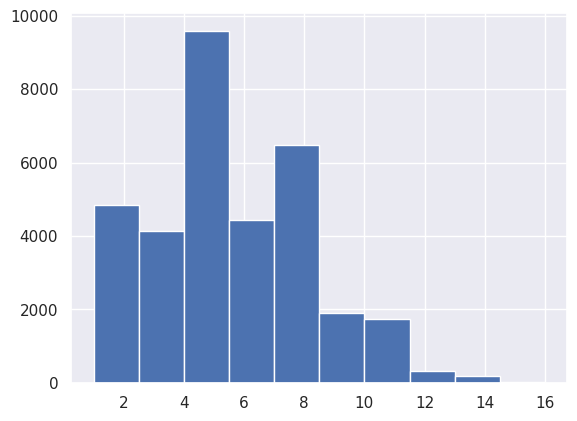

In [59]:
recommendation_frequencies[recommendation_frequencies["frequency"] == len(models)].value_counts("user").hist()

Text(0.5, 1.0, 'Recommendation order agreement (cutoff 20)')

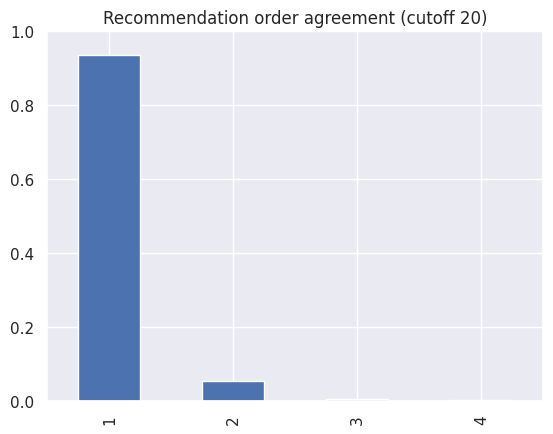

In [60]:
ax = recommendations_train_df.groupby(["user", "order"]).value_counts(
    subset=["value"]
).value_counts(normalize=True).plot.bar(ylim=(0, 1))
ax.set_title(f"Recommendation order agreement (cutoff {CUTOFF})")

Text(0.5, 1.0, 'Recommendation agreement (cutoff 20)')

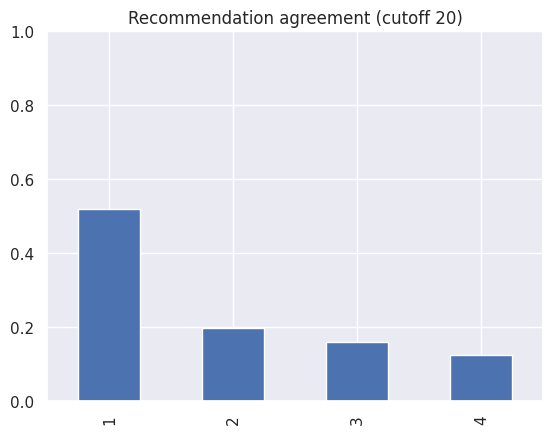

In [61]:
ax = recommendations_train_df.groupby("user").value_counts(subset=["value"]).value_counts(
    normalize=True
).plot.bar(ylim=(0, 1))
ax.set_title(f"Recommendation agreement (cutoff {CUTOFF})")

<Axes: >

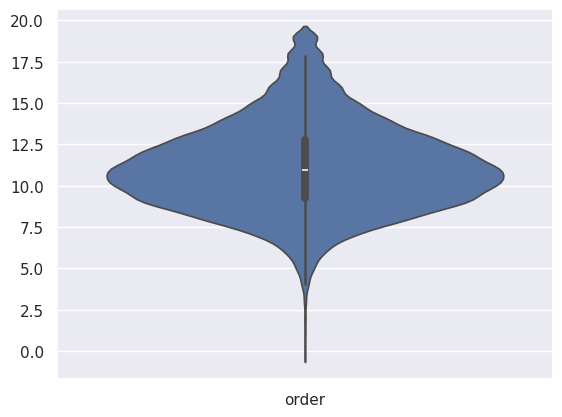

In [62]:
sns.violinplot(recommendations_train_df.groupby("value").aggregate({"order": "mean"}))

### Aggregating recommendations

In [63]:
recommendations_train_points = pl.from_pandas(recommendations_train_df).group_by("user", "value").agg(pl.col("points").sum())
recommendations_train_points

user,value,points
i64,i64,f64
32528,37655,0.35
7192,33515,0.5
276,9622,0.6
21544,30872,2.25
26199,7805,4.0
…,…,…
29609,37331,0.25
4365,6380,2.15
33500,14683,0.45


In [64]:
aggregated_recommendations = recommendations_train_points.sort("points", descending=True).group_by("user").head(10)
aggregated_recommendations

user,value,points
i64,i64,f64
5252,7063,3.95
5252,25731,3.55
5252,2559,3.15
5252,103,2.65
5252,22963,2.5
…,…,…
4183,3289,2.15
4183,6414,1.95
4183,11149,1.9


In [108]:
aggregated_recommendations.filter(pl.col("points") < pl.col("points").quantile(.25))

user,value,points
i64,i64,f64
5252,22964,1.75
5252,25335,1.75
21,12632,1.7
21,8659,1.5
21,8569,1.5
…,…,…
24095,27749,1.25
30276,12565,1.8
30276,36655,1.55


Text(0.5, 1.0, 'Point distribution (cutoff 20)')

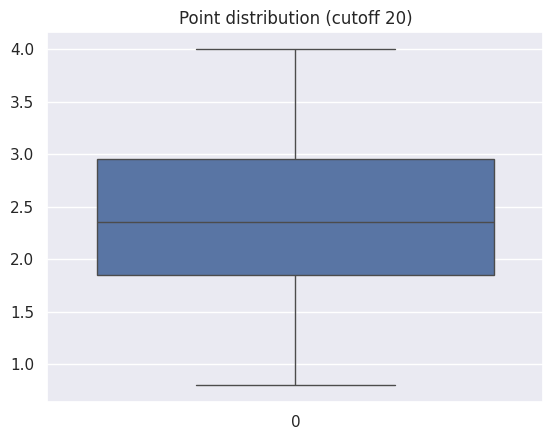

In [65]:
ax = sns.boxplot(aggregated_recommendations.select("points"))
ax.set_title(f"Point distribution (cutoff {CUTOFF})")

In [66]:
aggregated_recommendations_per_user = aggregated_recommendations.group_by("user").all().sort("user")
aggregated_recommendations_per_user

user,value,points
i64,list[i64],list[f64]
0,"[7547, 14888, … 9911]","[2.9, 2.75, … 1.3]"
1,"[6348, 13766, … 15600]","[3.4, 2.8, … 1.45]"
2,"[22714, 29964, … 1076]","[3.6, 2.85, … 1.35]"
3,"[6827, 25079, … 16956]","[3.6, 3.15, … 1.7]"
4,"[9812, 17624, … 3472]","[3.8, 3.45, … 1.5]"
…,…,…
34226,"[36844, 35548, … 38106]","[4.0, 3.65, … 1.8]"
34227,"[38027, 37719, … 36770]","[3.25, 3.2, … 1.8]"
34228,"[36263, 35394, … 36548]","[3.8, 3.35, … 1.55]"


In [67]:
recommendations_train_df[(recommendations_train_df["user"] == 34226) & (recommendations_train_df["value"] == 36844)]

,user,order,value,model,points
34226,34226,0,36844,itemknn_cfcbf,1.0
34226,34226,0,36844,user_wide_hybrid,1.0
34226,34226,0,36844,slim_elasticnet_fs,1.0
34226,34226,0,36844,rp3_icm,1.0


In [68]:
aggregated_recommendations_list = aggregated_recommendations_per_user.select("value").to_series().to_list()
len(aggregated_recommendations_list)

34231

## Export recommendations

In [37]:
do_export = bool(input("Export recommendations?"))
if not do_export:
    raise Exception("Aborted")

Exception: Aborted

In [25]:
type(recommender_object)

Recommenders.Hybrid.ScoresMultipleHybridRecommender

In [26]:
recommendations = recommend(recommender_object, test_df["user_id"].to_list())
# recommendations = aggregated_recommendations_list
print(len(recommendations))
print(len(recommendations[0]))

Chunk:   0%|          | 0/35 [00:00<?, ?it/s]

34231
10


In [27]:
test_df["item_list"] = [
    encode_recommendation(recommendation) for recommendation in recommendations
]
test_df

,user_id,item_list
0,0,572 7547 9911 14888 6380 2743 3074 3055 21614 531
1,1,6348 14748 13733 471 11875 572 6981 13006 1114...
2,2,29964 29963 21367 16255 17783 22714 22551 2270...
3,3,25079 25140 3671 25643 9115 6827 32004 7448 97...
4,4,17624 9812 15902 18647 9447 3472 15729 2637 86...
...,...,...
34226,35729,36844 36527 26093 35548 26794 37461 27346 2753...
34227,35730,28247 33330 37739 27350 37146 28119 37211 3709...
34228,35731,35394 38027 36263 37739 36548 28461 36525 3758...
34229,35734,37067 36880 36610 37550 36168 35093 35345 3706...


In [28]:
test_df.to_csv(SUBMISSION_PATH, index=False)